In [12]:
import numpy as np
import networkx as nx
rng = np.random.default_rng(1)
import matplotlib.pyplot as plt

In [13]:
def KL(p, q): # compute Kullback-Leibler divergence (d in paper). check edge cases.
    if (p == 0 and q == 0) or (p == 1 and q == 1) or p == 0:
        return 0
    elif q == 0 or q == 1:
        return np.inf
    else:
        return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))

def dKL(p, q): # derivative of KL wrt q, p is constant
    result = (p-q)/(q*(q - 1.0))
    return result

def newton(N, z, k, t, Q, precision = 1e-3, max_iterations = 50, epsilon=1e-6):
    p = z # from paper
    # print(f't={t}, p={p}')
    delta = 0.1
    q0 = min(p + delta, 1-epsilon) # initial guess
    q = q0
    converged = False

    for n in range(max_iterations):
        # if (p / q <= 0 or (1-p)/(1-q) <= 0): # sanity check for log domain errors
            # print(f'log error: p={p}, q={q}, n={n}')
        f = KL(p, q) - Q/N # rearrange upper confidence bound eqn
        df = dKL(p, q) # derivative of f is just derivative of KL
        
        if abs(df) < epsilon: break# check denominator is not too small
        
        qnew = max(q0, min(q - (f / df), 1-epsilon)) # chris: my approach for keeping q in (p,1)
        # print(f'q={q}, f(q)={f}, qnew={qnew}, precision={precision} n={n}')
        if(abs(qnew - q) < precision and abs(f) < precision): # check for early convergence
            converged = True
            # print(f'converged at {n} iterations')
            break
        q = qnew
    
    # if (not converged): print(f'did not converge')

    return q

In [14]:
rwd_means = [.2, .3, .4, .5, .6]
optimal_arm = np.argmax(rwd_means)
T = 1000
N = 4 # agents
M = 5 # arms
n = np.ones((N,M,T))
m = np.ones((N,M,T))
z = np.zeros((N,M,T))
x = np.zeros((N,M,T))
exp_cum_rwds = np.zeros((N, T))

G = nx.fast_gnp_random_graph(N, 0.5,directed=False) # undirected
while not nx.is_connected(G):
    G = nx.fast_gnp_random_graph(N, 0.5,directed=False)
nodes = list(G.nodes)
for i in nodes:
    G.add_edge(i,i)
A = nx.adjacency_matrix(G)
a = A.toarray() # make adjacency matrix an array for ease of use
neighbors = [] # list of all agents' neighbors
for i in range(len(a)):
    curr_neighbors = [] # neighbors of current agent
    for j in range(len(a)):
        if a[j][i] == 1:
            curr_neighbors.append(j)
    neighbors.append(curr_neighbors)
num_neighbors = [sum(A.toarray()[:,i]) for i in range(N)] # get cardinality of neighbors for each agentach agent

In [15]:
def Q(t, sigma, Ni):
    if (t > 1): return 3*(1+sigma)*(np.log(t) + 3*np.log(np.log(t)))/(2*Ni)
    return 0
    
# initialize a NxN weights matrix
W = np.zeros((N,N)) # W[i][j] is weight w_i,j
for agent in range(N):
    for neighbor in neighbors[agent]:
        if (agent != neighbor):
            W[agent][neighbor] = 1 / max(num_neighbors[agent], num_neighbors[neighbor])
        else:
            s = 0
            for nbor in neighbors[agent]:
                if (nbor != agent): s += 1 / max(num_neighbors[agent], num_neighbors[nbor])
            W[agent][neighbor] = 1 - s
# print(f'weights W:\n {W}')   

for agent in range(N):
    for arm in range(M):
        val = rng.uniform(rwd_means[arm]-.1, rwd_means[arm]+.1)
        z[agent, arm, 0] = val
        x[agent, arm, 0] = val
    
        
# print(f't=0, z is:\n {z[:,:,0]}')

for t in range(1,T):
    for agent in range(N):
        A = set()
        for k in range(M):
            if n[agent, k, t-1] <= m[agent, k, t-1] - M:
                A.add(k)
        if len(A) == 0:
            a = np.argmax([newton(n[agent, arm, t-1], z[agent, arm, t-1], arm, t-1, Q(t-1, 1, num_neighbors[agent])) for arm in range(M)])
        else:
            a = rng.choice(tuple(A))
        rwd = rng.uniform(rwd_means[a]-.1, rwd_means[a]+.1)
        # print(f'rwd={rwd}')
        exp_cum_rwds[agent][t] = exp_cum_rwds[agent][t-1] + rwd_means[a]
        # updates
        for arm in range(M):
            if arm == a:
                n[agent, arm, t] = n[agent, arm, t-1] + 1
            else:
                n[agent, arm, t] = n[agent, arm, t-1]
            x[agent, arm, t] = ((n[agent, arm, t-1] * x[agent, arm, t-1]) + rwd * (arm == a)) / n[agent, arm , t]
            z[agent, arm, t] = np.sum([W[agent][j] * z[j, arm, t-1] for j in neighbors[agent]]) + x[agent, arm, t] - x[agent, arm, t-1]
            m[agent, arm, t] = max(n[agent, arm, t], *[m[j, arm, t-1] for j in neighbors[agent]])
    # print(f't={t}, z is:\n {z[:,:,t]}')
    # print(f't={t}, x is:\n {x[:,:,t]}')
                

/var/folders/16/hk9qdzp172nbtb7pj39vw7ww0000gn/T/ipykernel_74105/3473644916.py:7: RuntimeWarning: divide by zero encountered in log
  theoretical_regret_bounds = [coeff * np.log(t) for t in time_axis] # not sure if allowed to do this bc of lim sup, seems like it works tho


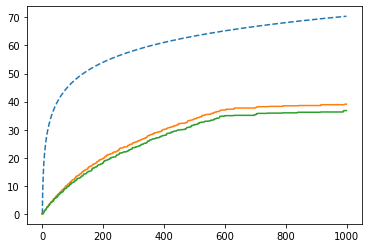

In [18]:
# compute regret
time_axis = list(range(T))
# plot theoretical regret bounds
coeff = 0
for i in range(M):
    if (i != optimal_arm): coeff += (rwd_means[optimal_arm] - rwd_means[i]) / (KL(rwd_means[i], rwd_means[optimal_arm]))
theoretical_regret_bounds = [coeff * np.log(t) for t in time_axis] # not sure if allowed to do this bc of lim sup, seems like it works tho
plt.plot(time_axis, theoretical_regret_bounds, '--')
# plot best and worst agent regrets
optimal_exp_cum_rwds = [[t * rwd_means[optimal_arm] for t in range(T)] for n in range(N)]
regrets = np.asarray(optimal_exp_cum_rwds) - exp_cum_rwds
plt.plot(time_axis, regrets[np.argmax(regrets[:, -1])])
plt.plot(time_axis, regrets[np.argmin(regrets[:, -1])])